## Project: Advanced Lane Finding

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Part 1: Pipeline of Advanced Lane Finding on Images

#### Camera Calibration

In [1]:
# Compute the camera calibration matrix and 
# distortion coefficients given a set of chessboard images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in fnames:
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If found, draw corners
    if ret == True:
    # Draw and display the corners
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

#### Test the result of Camera Calibration

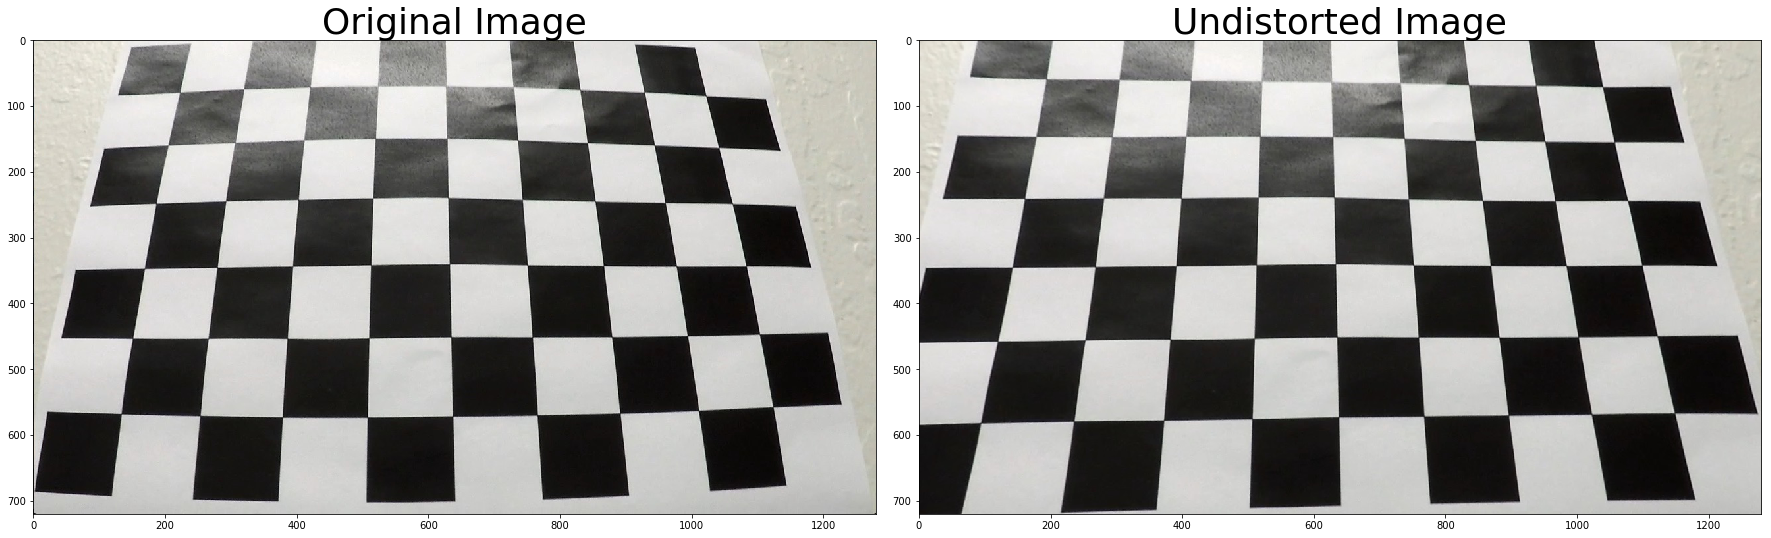

In [2]:
#test the camera calibration works or not
img = mpimg.imread('camera_cal/calibration3.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=36)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=36)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave("output_images/original_image",img)
mpimg.imsave('output_images/undistorted_image',undistorted)

#### Threshoding Binary Image for Color and Gradients

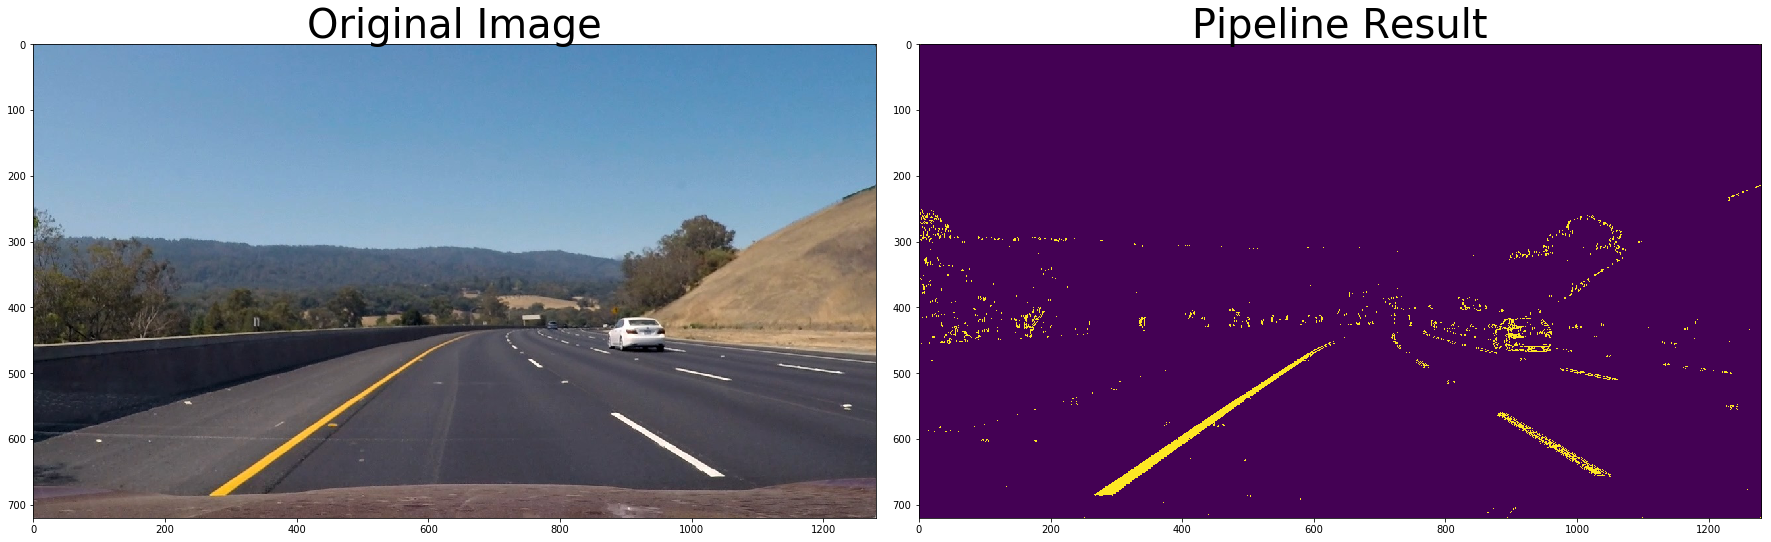

In [3]:
# Use color transforms, gradients, etc., to create a thresholded binary image.

image = mpimg.imread('test_images/test3.jpg')

# create color and gradient pipeline.
def pipeline(img, s_thresh=(130, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #return color_binary
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
img_threaded = pipeline(image, s_thresh=(170, 255), sx_thresh=(40, 100))
cv2.imwrite('output_images/threadholded_binary.png',img_threaded)
#result = cv2.undistort(img, mtx,dist, None, mtx)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(img_threaded)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Perspective Transform of Lane

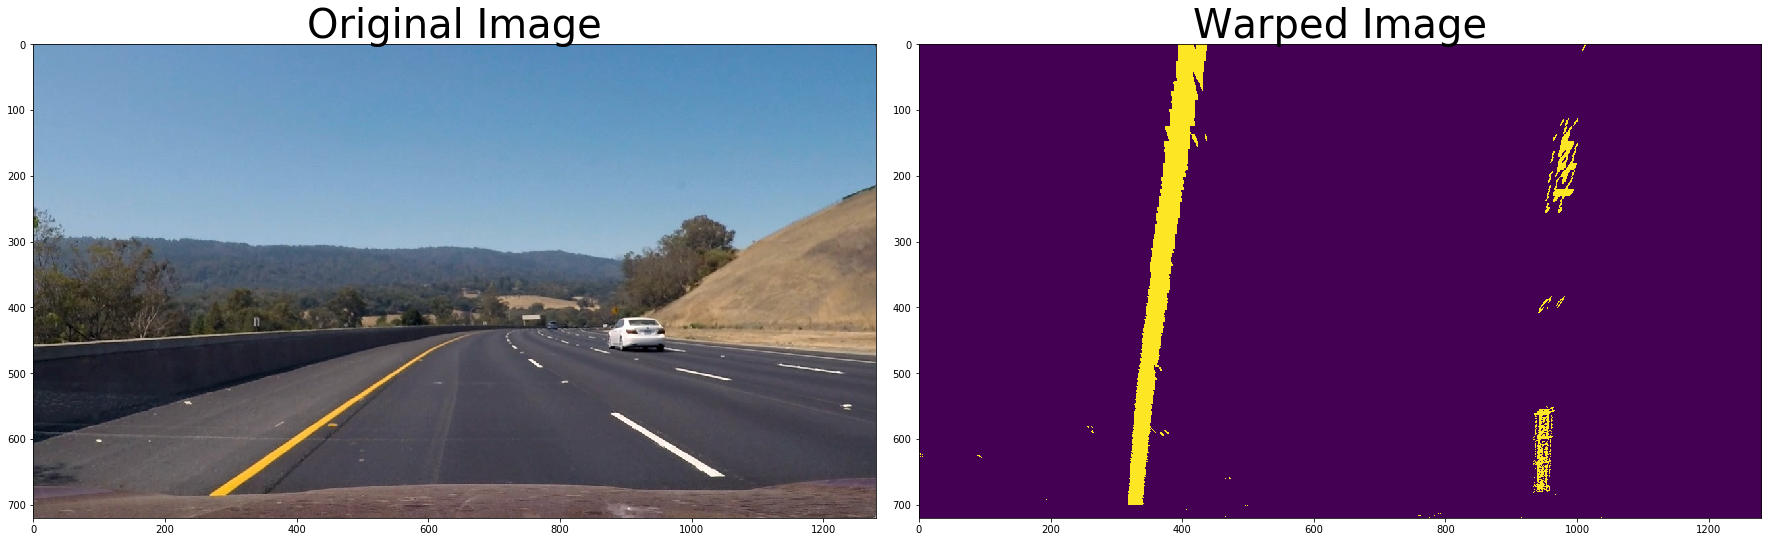

In [4]:
# Apply a perspective transform to rectify binary image ("birds-eye view")

# Load our image
img = mpimg.imread('test_images/test3.jpg')
img_size = (img.shape[1],img.shape[0])
#define 4 source points src = np.float32([[,],[,],[,],[,]])
     #Note: you could pick any four of the detected corners 
     # as long as those four corners define a rectangle
     #One especially smart way to do this would be to use four well-chosen
     # corners that were automatically detected during the undistortion steps
     #We recommend using the automatic detection of corners in your code
#define 4 destination points dst = np.float32([[,],[,],[,],[,]])
#use cv2.getPerspectiveTransform() to get M, the transform matrix
#use cv2.warpPerspective() to warp your image to a top-down view

src = np.float32([[722, 470],[1110, 720],[220,720],[570, 470]])

dst = np.float32([[920,1],[920, 720],[320,720],[320,1]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)
cv2.imwrite('output_images/img_warped.jpg',warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Detect Lane Pixels, Fit to Polynominal, and to Find Lane Boundary using Sliding Window

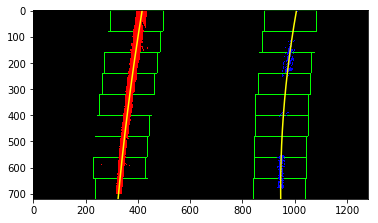

In [5]:
# Detect lane pixels and fit to find the lane boundary.

# Load our image
binary_warped = warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit


out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

#### Measure Radius of Curvatures

In [6]:
# Determine the curvature of the lane and vehicle position with respect to center
# we have polynomial fits and we can calculate the radius of curvature
# converting our x and y values to real world space in meters

def measure_curvature_real(left_fitx, right_fitx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    # the physical lane is about 30 meters long and 3.7 meters wide
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx,ploty)

print('left curvature: %.2f'% left_curverad, 'm', ';    right curvature: %.2f' % right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number


left curvature: 3376.46 m ;    right curvature: 1262.03 m


 #### Find Center of Lane

In [7]:
 # Distance from center is image height/2 - mean of left_fit and right_fit intercepts 
binary_warped = warped
h = binary_warped.shape[0]

def find_lane_center(binary_img, l_fit, r_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#     if left_fitx is not None and right_fitx is not None:
    if r_fit is not None and l_fit is not None:
        car_position = binary_ihttps://view5639f7e7.udacity-student-workspaces.com/notebooks/CarND-Advanced-Lane-Lines/p2.ipynb#Draw-the-Detected-Lane-Boundaries-onto-the-Original-Imagemg.shape[1]/2
#         l_fitx_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
#         r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
#         lane_center_position = (left_fitx + right_fitx) /2
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist


center_dist = find_lane_center(binary_warped, left_fit, right_fit)
print("the distance to the lane center is: ", center_dist, "m")

the distance to the lane center is:  0.0243945965 m


#### Draw the Detected Lane Boundaries onto the Original Image

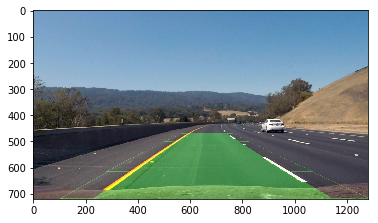

In [9]:
# Warp the detected lane boundaries back onto the original image
# to draw the detected lanes back on to the undistorted image

stacked_img = np.dstack((warped, warped, warped))*255
num_rows = warped.shape[0]
img_size = (stacked_img.shape[1],stacked_img.shape[0])

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(stacked_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0) #img is the original image to draw on

plt.imshow(result)

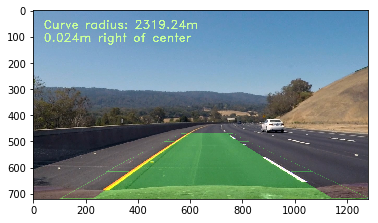

In [10]:
# Output visual display of the lane boundaries and numerical estimation 
# of lane curvature and vehicle position
# image = mpimg.imread('test_images/test3.jpg')
image = result

def draw_data_on_lane(result_img, curv_rad, center_dist):
    new_img = np.copy(result_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

data_on_original_image = draw_data_on_lane(image, (left_curverad+ right_curverad)/2, center_dist)
plt.imshow(data_on_original_image)

### Part 2: Consolidate the Pipeline for Advance Lane Finding and Test on Image

In [3]:
# func of camera calibration
def camera_calibration():
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # prepare object points
    nx = 9
    ny = 6

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Make a list of calibration images
    fnames = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in fnames:
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, draw corners
        if ret == True:
        # Draw and display the corners
            objpoints.append(objp)
            imgpoints.append(corners)
#             cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#             plt.imshow(img)
        # Use cv2.calibrateCamera() and cv2.undistort()
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    return ret, mtx, dist, rvecs, tvecs

In [4]:
# func to create a threshhold binary image
# create color and gradient pipeline.
def pipeline(img, s_thresh=(130, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #return color_binary
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary #which is img_threaded

In [5]:
# func to crate warped image (birds-eye-view)

def warped_image(img, img_threaded):
    img_size = (img.shape[1],img.shape[0])
    #define 4 source points src = np.float32([[,],[,],[,],[,]])
         #Note: you could pick any four of the detected corners 
         # as long as those four corners define a rectangle
         #One especially smart way to do this would be to use four well-chosen
         # corners that were automatically detected during the undistortion steps
         #We recommend using the automatic detection of corners in your code
    #define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    #use cv2.getPerspectiveTransform() to get M, the transform matrix
    #use cv2.warpPerspective() to warp your image to a top-down view

    src = np.float32([[722, 470],[1110, 720],[220,720],[570, 470]])
    dst = np.float32([[920,1],[920, 720],[320,720],[320,1]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)
    return warped,Minv

In [6]:
# finc to detect lane pixels 
# this func is to be called by fit_polynomial func below
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [7]:
# func to fit polynominal to a warped image to find the lane boundary
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit #out_img: lane line fitted binary image

In [8]:
# func of calculating left and right curvature in meters

def measure_curvature_real(left_fitx, right_fitx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    # the physical lane is about 30 meters long and 3.7 meters wide
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [16]:
# func to find lane center to the car
def find_lane_center(binary_img, l_fit, r_fit):
    h = binary_img.shape[0]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if r_fit is not None and l_fit is not None:
        car_position = binary_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

In [17]:
# func to draw the detected lanes on undistored/original image
# image: the original image to draw on
# return result, which is the overlapped lane detected image

def draw_detected_lane(warped,out_img,img,left_fitx, right_fitx, Minv):
    stacked_img = np.dstack((warped, warped, warped))*255
    num_rows = warped.shape[0]
    img_size = (stacked_img.shape[1],stacked_img.shape[0])

    y_points = np.linspace(0, num_rows-1, num_rows)
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))

    # Fills the area bounded by one or more polygons
#     cv2.fillPoly(stacked_img, np.int_([line_points]), [0,255, 0])
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0) #img is the original image to draw on

    return result

In [18]:
# func to put curvature and center to the lane data on the above lane detected image
def draw_data_on_lane(result_img,left_curverad, right_curverad, center_dist):
    new_img = np.copy(result_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    curv_radius = (left_curverad+ right_curverad)/2
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [19]:
# put pipeline of detecting lane line in one func
def advanced_lane_finding(img):
    vet,mtx,dist,rvecs,tvecs = camera_calibration()
    img_threaded = pipeline(img, s_thresh=(170, 255), sx_thresh=(40, 100))
    warped,Minv = warped_image(img, img_threaded)
    lane_detected_image,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)
    left_curverad,right_curverad = measure_curvature_real(left_fitx,right_fitx,ploty)
    center_dist = find_lane_center(warped,left_fit,right_fit)
    result_img = draw_detected_lane(warped,lane_detected_image,img, left_fitx,right_fitx,Minv)
    lane_data_detected_img = draw_data_on_lane(result_img,left_curverad,right_curverad,center_dist)
    return lane_data_detected_img

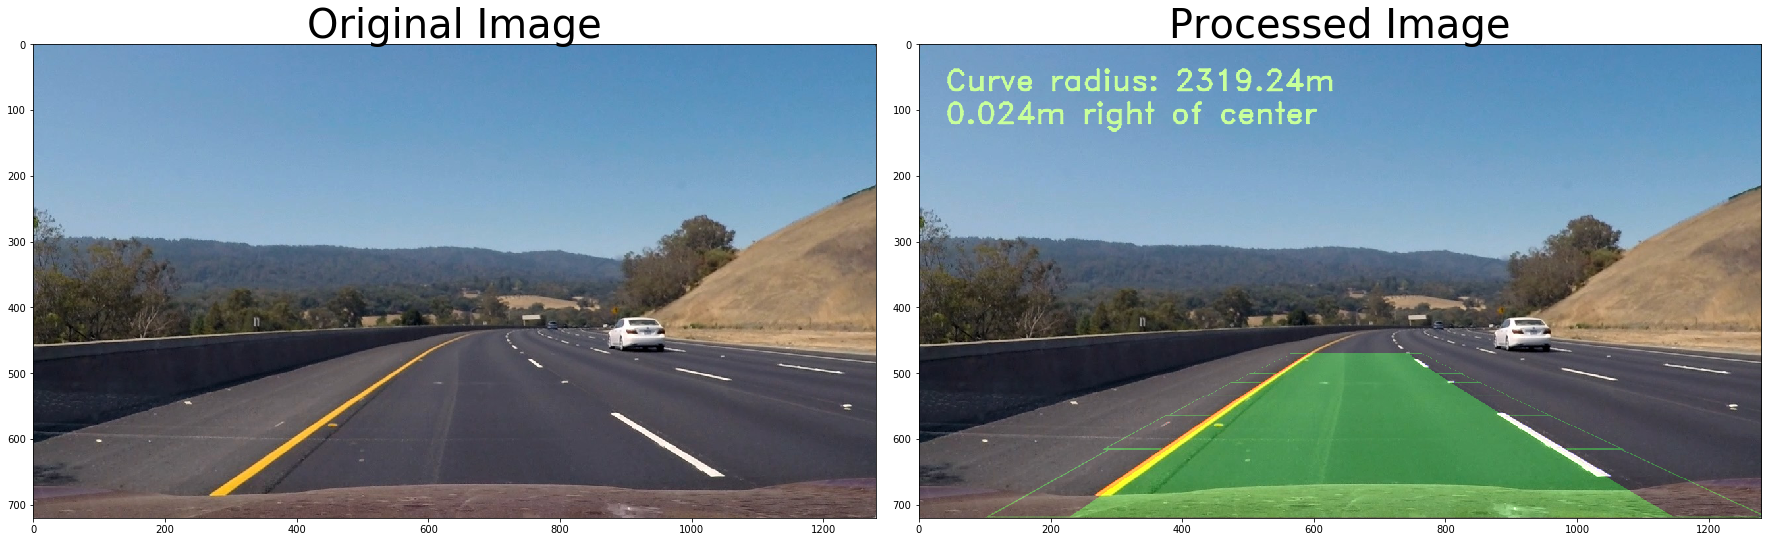

In [20]:
# test
img = mpimg.imread('test_images/test3.jpg')
lane_data_detected_img = advanced_lane_finding(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(lane_data_detected_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

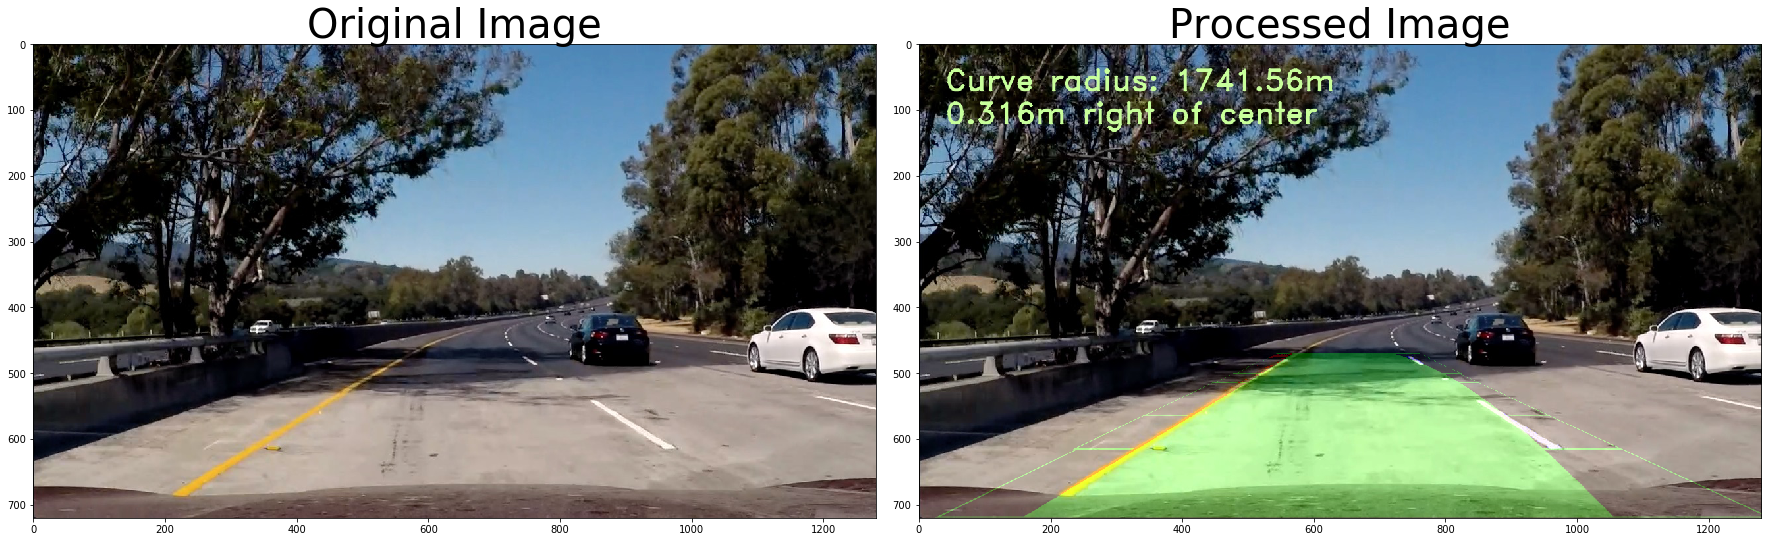

In [21]:
# read in image, and detect the lane line
img = mpimg.imread('test_images/test5.jpg')
lane_data_detected_img = advanced_lane_finding(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(lane_data_detected_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Part 3: Pipeline for Advance Lane Finding and Test on Videos

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output_name_1 = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
input_clip1 = VideoFileClip('project_video.mp4').subclip(0,5)
# clip1 = VideoFileClip('project_video.mp4')
output_clip1 = input_clip1.fl_image(advanced_lane_finding)
%time output_clip1.write_videofile(video_output_name_1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 99%|█████████▉| 125/126 [12:35<00:06,  6.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 12min 12s, sys: 6.23 s, total: 12min 18s
Wall time: 12min 38s


In [ ]:
video_output_name_2 = 'project_video_long_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# input_clip1 = VideoFileClip('project_video.mp4').subclip(0,5)
input_clip2 = VideoFileClip('project_video.mp4')
output_clip2 = input_clip2.fl_image(advanced_lane_finding)
%time output_clip2.write_videofile(video_output_name_2, audio=False)

[MoviePy] >>>> Building video project_video_long_output.mp4
[MoviePy] Writing video project_video_long_output.mp4


 99%|█████████▉| 1253/1261 [2:06:21<00:48,  6.05s/it] 

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output_name_3 = 'challenge_video_long_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#input_clip3 = VideoFileClip('challenge_video.mp4').subclip(0,5)
input_clip3 = VideoFileClip('challenge_video.mp4')
output_clip3 = input_clip3.fl_image(advanced_lane_finding)
%time output_clip3.write_videofile(video_output_name_3, audio=False)

[MoviePy] >>>> Building video challenge_video_long_output.mp4
[MoviePy] Writing video challenge_video_long_output.mp4


100%|██████████| 485/485 [49:11<00:00,  6.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_long_output.mp4 

CPU times: user 47min 35s, sys: 28.3 s, total: 48min 3s
Wall time: 49min 14s


In [ ]:
video_output_name_4 = 'harder_challenge_video_long_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#input_clip3 = VideoFileClip('challenge_video.mp4').subclip(0,5)
input_clip4 = VideoFileClip('harder_challenge_video.mp4')
output_clip4 = input_clip4.fl_image(advanced_lane_finding)
%time output_clip4.write_videofile(video_output_name_4, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_long_output.mp4
[MoviePy] Writing video harder_challenge_video_long_output.mp4


 29%|██▉       | 352/1200 [35:59<1:26:07,  6.09s/it]